# Finding the optimal portfolio allocations using the Markowitz Efficient Frontier method.

### Data can come from a Yahoo Finance download or from the Economist at Large Excel data. The returns can be monthly or weekly. 

###  The parameters of the efficient frontier function are 
- Returns : Dataframe containing monthly or weekly returns; with one column per symbol. It should be an m x n matrix with m observations for n securities.   
- short argument is whether short-selling is allowed; default is no (short selling prohibited)
- maxAllocation is the maximum % allowed for any one security (reduces concentration) 
- riskPremiumUp is the upper limit of the risk premium modeled (see for-loop below)
- riskIncrement is the increment value used in the for loop

In [89]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as pdr
import pandas_datareader.data as pdf
import datetime as dt
from datetime import datetime, timedelta

import quadprog #to use quadprog.solve_qp

from cvxopt import matrix, solvers

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Data from Yahoo Finance

In [4]:
# Run this to take data from Yahoo Finance
# symbols = ['AMZN','AAPL','GOOGL','INTC','MSFT']
symbolL = ["SPY","EFA","IWM"]
symbolWeight = [.20, .10, .10]
start = datetime(2017, 5, 28) #Thursday 5/25
end   = datetime(2017, 9, 1)

dataD={}
for symbol in symbolL:
    print( symbol )
    temp1 = pdr.get_data_yahoo(symbol, start, end)
    temp1["Symbol"] = symbol
    dataD[symbol] = temp1
# If you download too frequently, you will be temporarily timed out (error:"Unable to read url..")  

SPY
EFA
IWM


In [ ]:
# Run for Yahoo daily data
# Make a dataframe with just the weekly returns for each symbol
# the weekly log return is Friday's closing price minus Monday's closing price
symbolL=list(symbolD.keys())
wReturns=pd.DataFrame(columns=symbolL)
for symbol in symbolL:
    print( symbol )
    data = symbolD[symbol]
    # weekly adjusted closes
    #wAdjCloses = data[['Adj Close']].resample('W-FRI').last()-data[['Adj Close']].resample('W-MON').last()  # requires indices to match  
    mondays = data[['Adj Close']].resample('W-MON').last().reset_index(drop=True)
    fridays = data[['Adj Close']].resample('W-FRI').last().reset_index(drop=True)
    
    # Calculate the weekly wReturns from a stock's adjusted close
    # left join despite different index dates and add suffixes to column names
    fridays = pd.merge(fridays, mondays, on=None, how='left', suffixes=('_Fri','_Mon'),left_index=True, right_index=True) #(left|right)_index=True makes the merge happen on their indices.
    fridays['Returns']=(fridays['Adj Close_Fri'] - fridays['Adj Close_Mon'])
    fridays['PercentReturns']=100.*(fridays['Adj Close_Fri'] - fridays['Adj Close_Mon'])/fridays['Adj Close_Fri']
    wReturns[symbol] = fridays["PercentReturns"] #dataframe of weekly returns
    #wReturns.append(np.asarray(wAdjCloses)) #list of arrays
wReturns.head(3)

# Data from Economist At Large Excel workbook

In [401]:
# Run this to get data from the EcAtL Excel file
symbolL=["SPY","IWM","VWO","EFA","LQD","HYG"]
sheets = pd.read_excel("./Portfolio-Theory-Investment-Data-Monthly.xlsx",sheetname=symbolL,header=3)   
type(sheets)  # sheets is a dictionary of dataframes of the individual Excel sheets
type(sheets['SPY']) 

start = '2001-08-01' # "2001-08-01" # Full range
stop = '2010-01-04'   #"2010-01-04"
# start = '2007-06-01' # "2007-06-01"  # fully-filled dates
# stop = '2010-01-04'   #"2010-01-04"

dates=[pd.to_datetime(start),pd.to_datetime(stop)]
#dates=[pd.to_datetime(0),pd.to_datetime(0)]
symbolD = sheets
for symbol, df in symbolD.items():
    df0 = df.set_index('Date').sort_index() #starts with earliest dates
    df0 = df0.ix[start:stop,0:7]  # If we want all date ranges to match
    symbolD[symbol]=df0
    print("         symbol", symbol)#, "start", start, "stop", stop)
#     first = df0.index.min()
#     last = df0.index.max()
#     if first > dates[0]: # fix so it looks for nans?
#         dates[0]=start
#     if last < dates[1]:
#         dates[1]=stop
    
print("earliest and latest dates:\n",dates[0],"\n",dates[1])    
    
spyds=symbolD['SPY']
iwmds=symbolD['IWM']
vwods=symbolD['VWO']
efads=symbolD['EFA']
lqdds=symbolD['LQD']
hygds=symbolD['HYG'] 
# df for each symbol can be called by it's individual name (ie.spyds) 
# or as an item in the dictionary symbolD


         symbol VWO
         symbol EFA
         symbol SPY
         symbol LQD
         symbol HYG
         symbol IWM
earliest and latest dates:
 2001-08-01 00:00:00 
 2010-01-04 00:00:00


In [390]:
# Make a single df with just the monthly returns for the various symbols
# The monthly returns are (Adj_Close(t) - Adj_Close(t-1))/ Adj_Close(t-1)
symbolL=list(symbolD.keys())
mReturns=pd.DataFrame(index=list(symbolD[symbolL[0]].index))
for symbol in symbolL:
    temp1 = symbolD[symbol][["Monthly Return"]].rename(columns={"Monthly Return":symbol})
    mReturns = pd.merge(mReturns, temp1, on=None, how='left', left_index=True, right_index=True)
print("For dates:\n",dates[0],"\n",dates[1]) 
mReturns.head(3)

For dates:
 2001-08-01 00:00:00 
 2010-01-04 00:00:00


,VWO,EFA,SPY,LQD,HYG,IWM
2005-03-10,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,-0.023356,-0.016187,-0.018761,0.016192,NaN,NaN
2005-05-02,0.028795,-0.008547,0.032276,0.006171,NaN,NaN


In [391]:
mReturns.tail(3)
#mReturns

,VWO,EFA,SPY,LQD,HYG,IWM
2009-11-02,0.071698,0.039190,0.061547,0.019546,0.016935,0.031373
2009-12-01,0.031187,0.007105,0.019113,-0.020682,0.036755,0.079157
2010-01-04,-0.067317,-0.050651,-0.036342,0.012536,-0.018242,-0.037316


# Writing data to csv

In [392]:
# # Packaging the full downloaded data to save to a csv file
# # if you want to avoid having to download it each time
# # For data from Yahoo or Excel
# # Make a single df with data for one symbol stacked vertically 
# # below the data for another symbol
# symbolL=list(symbolD.keys())
# cols=list(symbolD[symbolL[0]].columns)
# cols = cols.append("Symbol")
# alldf = pd.DataFrame(columns=cols) 

# for symbol in symbolL: 
#     print("symbol", symbol)
#     temp1=symbolD[symbol]
#     temp1['Symbol'] = str(symbol)
#     alldf =pd.concat([alldf, temp1], axis=0) #stack next df blow, as new rows
# alldf.head(3)

# # weekly returns
# wReturns.to_csv("wReturns_data.csv")
# # monthly returns
# mReturns.to_csv("mReturns_data.csv")

# Summarizing the data

In [393]:
# Look at average returns for the dates from start to stop
summary = pd.DataFrame({'% Ave Returns':np.mean(mReturns, axis = 0)*100,
                        '% Std Dev':np.std(mReturns, axis = 0)*100})
type(summary)
print('Dates:', dates[0], " to ", dates[1])
summary

# Dates: 2001-08-01 00:00:00  to  2010-01-04 00:00:00
# 	% Ave Returns	% Std Dev # roughly matches EcAtLarge
# VWO	1.373503	8.011100
# EFA	0.356678	5.997324
# SPY	0.108283	4.668547
# LQD	0.351329	2.858216
# HYG	0.293817	5.730999
# IWM	0.255663	6.087090

# 	 Average Monthly Return	Standard Deviation From EcAtLarge

#  VWO	 1.37%	 8.08%
#  EFA	 .54%	 5.46% #
#  SPY	 .19%	 4.53% #
#  LQD	 .47%	 2.65% #
#  HYG	 .29%	 5.82%
#  IWM	 .53%	 6.02% #

Dates: 2001-08-01 00:00:00  to  2010-01-04 00:00:00


,% Ave Returns,% Std Dev
VWO,1.373503,8.011100
EFA,0.356678,5.997324
SPY,0.108283,4.668547
LQD,0.351329,2.858216
HYG,0.293817,5.730999
IWM,-0.520395,7.311764


In [394]:
# Let's see the correlation matrix 
# (Correlation matrix is like a normalized covariance matrix. I use it here because the correlation function ignores nans whereas the covariance matrix gives nans for any missing return value)

correlation = mReturns.corr()

#allReturns = np.asarray(mReturns[['VWO','EFA']]) #np.cov requires array
#covariance = np.cov(allReturns, rowvar=0)  # not using np.cov bc it doesn't work with nans

print(correlation.shape)
print("correlation")
print('Dates:', dates[0], " to ", dates[1])
correlation

(6, 6)
correlation
Dates: 2001-08-01 00:00:00  to  2010-01-04 00:00:00


,VWO,EFA,SPY,LQD,HYG,IWM
VWO,1.000000,0.908802,0.838727,0.343254,0.694134,0.797515
EFA,0.908802,1.000000,0.909643,0.475779,0.774638,0.868858
SPY,0.838727,0.909643,1.000000,0.392078,0.756804,0.939409
LQD,0.343254,0.475779,0.392078,1.000000,0.738500,0.384730
HYG,0.694134,0.774638,0.756804,0.738500,1.000000,0.805202
IWM,0.797515,0.868858,0.939409,0.384730,0.805202,1.000000


# Creating the efficient frontier function

In [463]:
#### Efficient Frontier function ####

def eff_frontier(Returns, short="no", maxAllocation=None, \
                 riskPremiumUp=.5, riskIncrement=.005):
# return argument should be a m x n matrix with one column per security
# short argument is whether short-selling is allowed; default is no (short
# selling prohibited)
# maxAllocation is the maximum % allowed for any one security (reduces concentration) 
# riskPremiumUp is the upper limit of the risk premium modeled (see for loop below) and 
# riskIncrement is the increment value used in the for loop
    symbols=list(Returns.columns)
    allReturns = np.asarray(Returns)
#     covariance = np.asarray(mReturns.corr())
    covariance = np.cov(allReturns, rowvar=0)
    n = len(symbols)
# Create initial Amat and bvec assuming only equality constraint
# (short-selling is allowed, no allocation constraints)
    ones=[1.]*n
    Amat = np.diag(ones)  # construct an n x n diagonal matrix with values as the diagonal terms, [r] Amat = matrix (1, nrow=n)
    bvec = 1.
    meq = 1.
# Then modify the Amat and bvec if short-selling is prohibited
    if short =="no": #second
        Amat = np.column_stack((ones, Amat)) #[r] Amat = cbind(1, diag(n))
        bvec = [1.]+[0.]*n #[r] c(bvec, rep(0, n))
        # Amat should be shape (n x n+1) and bvec will be (n+1, )
# And modify Amat and bvec if a max allocation (concentration) is specified
    if maxAllocation != None:
        if any([maxAllocation > 1, maxAllocation <0]):
            stop("maxAllocation must be greater than 0 and less than 1")
    if (maxAllocation * n) < 1:
        stop("Need to set maxAllocation higher; not enough assets to add to 1")
    Amat = np.column_stack((Amat, -np.diag(ones)))
    bvec = np.array(bvec+[-maxAllocation]*n) # [r] bvec = c(bvec, rep(-maxAllocation, n))
    # 
    # # Calculate the number of loops
    iL=np.arange(0.0, riskPremiumUp+riskIncrement, riskIncrement) #include riskPremiumUp, which is entered as a function argument
    #
    # # Initialize a matrix to contain allocation and statistics
    # # This is not necessary, but speeds up processing and uses less memory
    eff = pd.DataFrame(index=iL, columns=symbols+["% Std_Dev", "% Exp_Return","Sharpe"])
    # # Loop through the quadratic program solver
    for i in iL:
        aveReturns =np.mean(allReturns, axis=0)
        dvec = aveReturns * i # This moves the solution along the EF
#         if i == iL[2]: # inputs
#             print('covariance', covariance.shape, type(covariance)) # make sure every input is numpy array
#             print('     ', covariance[0,:])
#             print('dvec', dvec.shape, type(dvec))
#             print('     ', dvec)
#             print('Amat', Amat.shape, type(Amat))
#             print('     ', Amat[0,:])
#             print('bvec', bvec.shape, type(bvec))
#             print('     ', bvec)
        sol = quadprog.solve_qp(covariance, dvec, Amat, bvec, meq)
        #sol = quadprog.solve_qp(Dmat, dvec, Amat, bvec) # Keep for reference
        Solution = sol[0]
        Value = sol[1]
        UnconstrainedSol = sol[2]
        Iterations = sol[3]
        Lagrangian = sol[4]
        iact = sol[5]
#         if i == iL[0]: # outputs
#             #print("sol", len(sol), sol)
#             print("Solution", Solution)
#             print("Value", Value)
#             print("UnconstrainedSol", UnconstrainedSol)
#             print("Iterations", Iterations)
#             print("Lagrangian", Lagrangian)
#             print("iact", iact)
        eff.loc[i,"% Std_Dev"]    = np.sqrt(sum(Solution*np.sum((covariance*Solution), axis=0)))*100
        eff.loc[i,"% Exp_Return"] = (Solution @ aveReturns)*100  # In R, %*% is matrix or vector (dot) product
        eff.loc[i,"Sharpe"]     = eff.loc[i,"% Exp_Return"] / eff.loc[i,"% Std_Dev"]
        eff.loc[i,symbols]      = Solution
    return(eff)

# Solving for the efficient frontier

In [486]:
# Pick dates
# start = '2007-06-01' # "2007-06-01" # dates with no nans
# stop = '2010-01-04'   #"2010-01-04"
start = '2001-08-01' # "2001-08-01" # Full range
stop = '2010-01-04'   #"2010-01-04"
dates=[pd.to_datetime(start),pd.to_datetime(stop)]
mReturns = mReturns.ix[start:stop,:]

For dates: 2001-08-01 00:00:00  to  2010-01-04 00:00:00

 Highest achieved Sharpe value 0.0460766177338

 effOptimalPoint


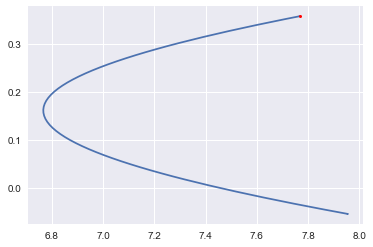

In [493]:
# # Run the eff.frontier function based on no short and 50% alloc. restrictions
# eff = eff_frontier(wReturns, short="no", maxAllocation=.50,
#  riskPremiumUp=1, riskIncrement=.1) #risk.increment=.001 originally
# print(eff.head())
# eff.tail()

# Run the eff.frontier function based on no short and 50% alloc. restrictions
# monthly returns from the Excel file
# riskPremiumUp <= maxAllocation makes sense, upper end of curve
eff = eff_frontier(mReturns, short="no", maxAllocation=.60,
 riskPremiumUp=0.3, riskIncrement=.001) #risk.increment=.001 originally
#print(eff.head(3))

maxSharpe=max(eff.Sharpe)
print('For dates:', dates[0], " to ", dates[1])
print('\n Highest achieved Sharpe value', maxSharpe)

# Find the optimal portfolio
effOptimalPoint = eff.loc[eff.Sharpe == max(eff.Sharpe), : ]
effOptimalPoint = effOptimalPoint.iloc[0] # Take the first row, if there happen to be multiple rows with max Sharpe value
print('\n effOptimalPoint')
effOptimalPoint.head()

# Efficient Frontier Plot
xvals=eff['% Std_Dev']
yvals=eff['% Exp_Return']
plt.plot(xvals, yvals)

xmax=effOptimalPoint['% Std_Dev']
ymax=effOptimalPoint['% Exp_Return']
plt.plot(xmax, ymax, marker='o', markersize=3, color='red', label='Optimal Portfolio')


# For dates: 2007-06-01 00:00:00  to  2010-01-04 00:00:00
# The optimal portfolio has 50% LQD, 45% HYG, and 5% VWO. 
# It's return is 0.35%
# It's risk is 7.8%

# For full dates, I get nans

# The set with the highest Sharpe Ratio (or slope) is the optimal portfolio.  
# In this set, an investor with these six investment alternatives
# should consider investing 44% in VWO and 56% in LQD. (EcAtL for full dates)

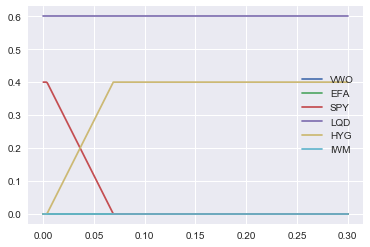

In [515]:
# Allocation of various products
yvals=eff.iloc[:,0:6]
labels=list(eff.columns[0:6])

lineObjects = plt.plot(yvals) #, label=labels)
plt.legend(lineObjects, labels)


Sharpe ration as a function of the index i


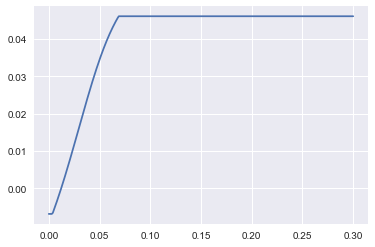

In [494]:
yvals=eff['Sharpe']
plt.plot( yvals)
print('Sharpe ration as a function of the index i')

Sharpe ration as a function of the index i


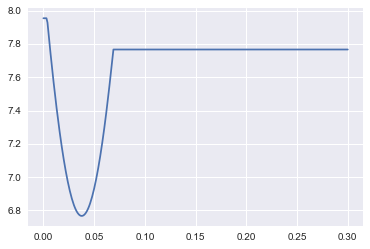

In [495]:
yvals=eff['% Std_Dev'] # Standard deviation isn't changing much
plt.plot( yvals)
print('Sharpe ration as a function of the index i')

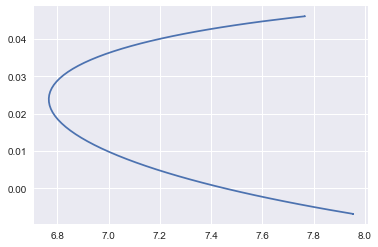

In [496]:
xvals=eff['% Std_Dev']  
yvals=eff['Sharpe']
plt.plot(xvals, yvals)

In [510]:
type(eff)
list(eff.columns[0:3])

['VWO', 'EFA', 'SPY']

In [488]:
eff.head(3)

,VWO,EFA,SPY,LQD,HYG,IWM,% Std_Dev,% Exp_Return,Sharpe
0.000,-2.77556e-17,-1.79225e-16,0.431284,0.5,0.068716,0,7.77741,-0.0976565,-0.0125564
0.001,-2.77556e-17,-1.79088e-16,0.425157,0.5,0.0748431,0,7.71746,-0.0913429,-0.0118359
0.002,0,-1.78952e-16,0.41903,0.5,0.0809702,1.38778e-17,7.65901,-0.0850294,-0.0111019


In [489]:
eff[.30:.45]

,VWO,EFA,SPY,LQD,HYG,IWM,% Std_Dev,% Exp_Return,Sharpe
0.3,3.71231e-16,-8.12724e-16,5.4703e-16,0.5,0.5,-5.10399e-17,8.26705,0.346751,0.0419437


In [301]:
# Output from R version
# weekly.returns    weekly.returns.1    Std.Dev
# 2	0.5	0.5	0.019537	
# 3	0.5	0.5	0.019537
# Std.Dev    Exp.Return      sharpe
# 0.019537	-0.006155004	-0.3150434
# 0.019537	-0.006155004	-0.3150434

In [102]:
# qp_G = Dmat   =  covariance 
#        matrix appearing in the quadratic function to be minimized.     
# qp_C = ? dvec ?
#        vector appearing in the quadratic function to be minimized.
# qp_a = Amat
#        matrix defining the constraints under which we want to minimize the quadratic function.
# qp_b = bvec
#        vector holding the values of b0 (defaults to zero).
# meq  = meq
#        the first meq constraints are treated as equality constraints, all further as inequality constraints (defaults to 0).

#sol <- solve.QP(covariance, dvec=dvec, Amat=Amat, bvec=bvec, meq=meq)
#sol = quadprog.solve_qp(qp_G, qp_C, qp_a, qp_b, meq)[0]

# Example:
# Dmat       <- matrix(0,3,3)
# diag(Dmat) <- 1
# dvec       <- c(0,5,0)
# Amat       <- matrix(c(-4,-3,0,2,1,0,0,-2,1),3,3)
# bvec       <- c(-8,2,0)
#solve.QP(Dmat,dvec,Amat,bvec=bvec)

Dmat = np.diag([1.]*3)  #diagonal matrix I=1
dvec = np.array([0.,5.,0.])
Amat = matrix([-4.,-3.,0.,2.,1.,0.,0.,-2.,1.],(3,3))
bvec = np.array([-8., 2., 0.]).reshape((3,))
meq  =  0 #same as omitting meq

sol = quadprog.solve_qp(Dmat, dvec, Amat, bvec)
sol

(array([ 0.47619048,  1.04761905,  2.0952381 ]),
 -2.380952380952381,
 array([ 0.,  5.,  0.]),
 array([3, 0], dtype=int32),
 array([ 0.        ,  0.23809524,  2.0952381 ]),
 array([3, 2], dtype=int32))